## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os ,shutil ,copy ,time ,gc  ,random , timm
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,f1_score
from tqdm.notebook import tqdm
import torch ,torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import utils
from torchvision import datasets, transforms ,models
from torch.cuda.amp import GradScaler ,autocast
from IPython import display as ipdisplay
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## seed Everything 
For Reproducibility 

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()
    gc.collect()
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.emit_nvtx(enabled=False, record_shapes=False)
    torch.autograd.profiler.profile(enabled=False)
seed_everything(6)

In [3]:

def add_Experiment(model_p, pramas,opt,lossfn,loader_v,transform_t,transform_v,comment='',warning_commet=True):
    path= 'Experiments/'
    sub_id="amr"
    comment = ""
    if not os.path.isdir('Experiments'):
        os.mkdir('Experiments')
    if not os.path.isfile('Experiments/Experiments.csv'):
        pd.DataFrame(columns=["Experiment_id",
                              "Acc_t","Acc_v",
                              "Loss_t","Loss_v",
                              "epochs","Batch", 
                              "time_ep(min)",
                              "Model_name",
                              "Model_prams",
                              "pre_weights",
                              "opt_Name",
                              "opt_learning_rate",
                              "opt_betas",
                              "opt_decay",
                              "lossfn_name",
                              "lossfn_reduction",
                              "lossfn_class_weights",
                              "classes_num",
                              "classes_names",
                              "sampels/class",
                              "Augmentation_T",
                              "Augmentation_V",
                              "NoteBook_file_name",
                              "weights_file_name",
                              "fig_file_name",
                              "comment"]).to_csv(path+'Experiments.csv',index= False)
        
    
    if warning_commet:
        comment = input('if you dont pass comment you can write one or interrupt the kernal. ')
    
    df= pd.read_csv(path+'Experiments.csv')
    exp_id=sub_id+f"{len(df):06}"
    ep= model_p.history['Validation_Accuracy'].argmax()
    loss_t , acc_t,loss_v,acc_v,_= model_p.history.iloc[ep,:]
    ep_time= model_p.history['epoch_time'].mean()/60
    m= ModeL(pramas['n_classes']).to(device) 
    m.Load_Weights('Best_model_on_valdtion.pt')
    fig,ax= m.model_data_monitor(loader_v, lossfn)
    ipdisplay.clear_output()
    model_w_file= 'Exp_'+exp_id+'.pt'
    model_fig= 'Exp_'+exp_id+'.png'
    note_book= 'Exp_'+exp_id+'.ipynb'

    exp={"Experiment_id":exp_id,
         "Acc_t":acc_t,
         "Acc_v":acc_v,
         "Loss_t":loss_t,
         "Loss_v":loss_v,
         "epochs":ep,
         "Batch":pramas['batchsize'], 
         "time_ep(min)": ep_time,
         "Model_name":model_p.name,
         "Model_prams":model_p.pramters_number,
         "pre_weights":model_p.pre_trained_w,
         "opt_Name":str(type(opt))[20:-2],
         "opt_learning_rate":pramas['learning_rate'],
         "opt_betas":pramas['betas'],
         "opt_decay":pramas['weight_decay'],
         "lossfn_name":str(lossfn)[:-2],
         "lossfn_reduction":lossfn.reduction,
         "lossfn_class_weights":lossfn.weight.tolist(),
         "classes_num":pramas['n_classes'],
         "classes_names":pramas['sub_classes'],
         "sampels/class":pramas['samples_per_class'],
         "Augmentation_T":transform_t.transforms,
         "Augmentation_V":transform_v.transforms,
         "NoteBook_file_name":note_book,
         "weights_file_name":model_w_file,
         "fig_file_name":model_fig,
         "comment":comment}
    
    df = df.append(exp,ignore_index=True)
    shutil.copyfile('Best_model_on_valdtion.pt',path+model_w_file)
    shutil.copyfile('train.ipynb',path+note_book)
    fig.savefig(path+model_fig)
    df.to_csv(path+'Experiments.csv',index= False)
    print("Experiment recorded")
    
def delet_Experiment(exp_id):
    path= 'Experiments/'
    model_w_file=path+ 'Exp_'+exp_id+'.pt'
    model_fig= path+'Exp_'+exp_id+'.png'
    note_book= path+'Exp_'+exp_id+'.ipynb'
    df= pd.read_csv(path+'Experiments.csv')
    idx = df.loc[df['Experiment_id'] == exp_id,:].index
    df.drop(idx,inplace=True)
    
    if os.path.isdir( model_w_file):
        os.remove(model_w_file)
        print(f'model wieght {model_w_file} deleted')
    if os.path.isdir( model_w_file):
        os.remove(model_fig)
        print(f'model conf matrix {model_fig} deleted')
    if os.path.isdir( model_w_file):
        os.remove(note_book)
        print(f'model Note Book {note_book} deleted')
    df.to_csv(path+'Experiments.csv',index= False)

### Data Loader Function

In [4]:
def load_date(image_transformtions ,batch_size=32, 
              load_classes=[] ,n_samples_per_class=None, Set ='train',verbose = True):  
    assert (len(load_classes) != 1 ) , f"Number Of Classes Must be at least two"
    classes =['bus', 'crossover', 'hatchback', 'motorcycle', 'pickup-truck', 'sedan', 'truck', 'van']
    PATH = 'A:/Aiactive/'
    if (len(load_classes) ==0):     
        data_dir = PATH + Set 
    else : 
        for c in load_classes:
             assert (c in classes) , f"classes you want to keep dosnot match {classes}"
        data_dir = PATH +'datasymbolic/'+Set
        shutil.rmtree(data_dir) if os.path.isdir(data_dir) else ''
        os.mkdir(data_dir)
        [os.symlink(PATH+Set+'/'+clas,data_dir+'/'+clas ) for clas in load_classes]
    
        
    dataset = datasets.ImageFolder(data_dir, transform=image_transformtions) 
    df = pd.DataFrame(dataset.imgs,columns=['image','Labels'])
    df =  df.sample(frac=1, replace=False, random_state=6).reset_index(drop=True)
    g= pd.DataFrame(df.groupby('Labels').size() ,columns=['Found_Samples'])
    g['Class'] = dataset.class_to_idx.keys()
    g =g[['Class','Found_Samples']]
    
    if n_samples_per_class != None:
        df = df.groupby('Labels').sample(n=n_samples_per_class, replace=True, random_state=6)
      
    df =df.groupby('Labels').sample(frac=1, replace=False, random_state=6)
    g['Loaded_Samples'] = pd.DataFrame(df.groupby('Labels').size() ,columns=['samples'])['samples']
    #g.iloc[1,0]
    
    sampler = torch.utils.data.SubsetRandomSampler(df.index.tolist())
    drop_last =  True if Set =='train' else False
    dataloader = torch.utils.data.DataLoader(dataset,
                                             sampler=sampler,
                                             batch_size=batch_size, 
                                             shuffle=False ,
                                             pin_memory=True,
                                             drop_last= drop_last,
                                             num_workers=2) 
    if verbose:
        print(f'Sampels Found by loader') 
        display(g)

    return dataloader

In [5]:
#timm.create_model('adv_inception_v3', pretrained=0) 

###  Model 

In [6]:
class ModeL(nn.Module):
    def __init__(self, n_classes,imagenet_weights=True,device= 'cuda'):
        super(ModeL, self).__init__()
        self.name = 'adv_inception_v3'
        self.pre_trained_w = imagenet_weights
        
        self._creat_Model(n_classes,imagenet_weights)
        
        self.history =pd.DataFrame(columns=["Training_Loss","Training_Accuracy","Validation_Loss","Validation_Accuracy","epoch_time"])
        self.pramters_number = self.model_Info()
        
        
    def _creat_Model(self,out_features , pretrained=True):
        self.model = timm.create_model(self.name, pretrained=pretrained)   
        in_f = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_f, out_features=out_features, bias=True),
            nn.LogSoftmax(dim=1) ) 
        self.model.to(device)
        
    
    def model_Info(self,summary =False ):
        prams=0
        for p in list(self.model.parameters()):
            prams += p.nelement()
        prams = np.round(prams/10**6,2)
        if summary:
            print(f'model parameters: {prams} M')
            print(torchinfo.summary(model)) if summary else ''
        return prams
    
    def Load_Weights(self,load_weights_path ):
        state = torch.load(load_weights_path)
        self.load_state_dict(state['state_dict'])

    @autocast()    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def _track_history(self,T_Loss,T_Acc,V_Loss,V_Acc,t_ep):
        s = pd.Series([T_Loss,T_Acc,V_Loss,V_Acc,t_ep] ,index= self.history.columns)
        self.history = self.history.append(s,ignore_index=True)
        
    def save_model(self,best_metric,current_metric,name,epoch):
        if current_metric >= best_metric:
            state = {'epoch': epoch,
                     'state_dict': self.state_dict()}
            torch.save(state, name+'.pt')
            best_metric = current_metric
            print(f"%s is Saved with metric :%.3f" % (str(name).replace("_"," "),best_metric ))
        return best_metric
    
    def train_one_epoch(self, loader_train, criterion, optimizer,scaler ,device= 'cuda'):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        ###################
        # train the model #
        ###################
        self.model.train()
        for  (data, target) in tqdm(loader_train):
            # move tensors to GPU if CUDA is available
            data ,target = data.to(device), target.to(device )
            #clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            # calculate the batch loss
            predictions = self.model(data)
            loss = criterion(predictions, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            optimizer.step()
            acc= (predictions.argmax(dim=1) == target).cpu().numpy().mean()
            # one steps
            epoch_loss +=loss.detach().item()
            epoch_accuracy += acc
            #del predictions ,data , target ,loss,acc
            #gc.collect()
            #torch.cuda.empty_cache()
        return  epoch_loss/len(loader_train), epoch_accuracy/len(loader_train)
        
    def _validate_one_epoch(self, loader, criterion, device= 'cuda'):
        # keep track of validation loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        self.model.eval()
        y_df = pd.DataFrame(columns= ["Target","predictions"])
        ######################
        # validate the model #
        ######################
        for data, target in loader:
            # move tensors to GPU if CUDA is available
            data ,target = data.to(device), target.to(device)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                
                predictions = self.model(data)
                # calculate the batch loss
                loss = criterion(predictions, target)
                # Calculate Accuracy
                acc = (predictions.argmax(dim=1) == target).cpu().numpy().mean()
                # update average validation loss and accuracy
                epoch_loss += loss.detach().item()
                epoch_accuracy += acc
                
            y_df = y_df.append(pd.DataFrame({"Target":target.cpu().numpy().reshape(-1) ,
                                            "predictions":predictions.argmax(dim=1).cpu().numpy().reshape(-1)  }),
                                                   ignore_index=True)
        
       # del predictions ,data , target ,loss,acc
       # gc.collect()
        #torch.cuda.empty_cache()
        return  epoch_loss/len(loader), epoch_accuracy/len(loader),y_df 
    
    def validate_one_epoch(self, loader, criterion, device= 'cuda'):
        loss,acc,y_df =self._validate_one_epoch(loader, criterion, device= device)
        f1= f1_score(y_df["Target"].tolist(), y_df["predictions"].tolist(), average='macro')
        return loss,acc , f1
    
    def plot_history(self):
        fig,ax=plt.subplots(1,2,figsize = (16,4))
        ax[0]= self._plot(ax[0], self.history.index+1,self.history['Training_Loss'],self.history['Validation_Loss'],'Loss' )
        ax[1]= self._plot(ax[1], self.history.index+1,self.history['Training_Accuracy'],self.history['Validation_Accuracy'],'Accuracy')
        #ax[1].set_ylim([.20, .80])
        plt.show()
        
    def _plot(self, ax, ep,trian,val,plot_name ):
        ax.plot(ep, trian,label = "Training",color = 'blue')
        ax.plot(ep, val ,label = "Valdtion",color = 'red')
        ax.set_title(f"{plot_name} per Epoch",font ={'weight' : 'bold'}) 
        ax.legend()
        ax.set_xlabel("Epochs",font ={'weight' : 'bold'})
        ax.set_ylabel(f"{plot_name}",font ={'weight' : 'bold'})
        return ax
    
    def model_data_monitor(self,loader, criterion, device= 'cuda' ): 

        loss, acc, y_df = self._validate_one_epoch( loader, criterion, device= device)
        y_df["eq"] = (y_df["Target" ] == y_df["predictions" ])
        mapper = {v:k for k,v in loader.dataset.class_to_idx.items()}
        y_df["Target" ] = y_df["Target" ].map(mapper) 
        y_df["predictions" ] = y_df["predictions"].map(mapper) 
        g= y_df.groupby(['Target','eq'])\
                .agg('size').div(y_df.shape[0])\
                .sort_index( ascending=[True,False]).unstack()

        plt.rc('font', **{'size'   : 13})
        print(f'Accuracy : {g.sum(0).values[1]} ,Error:{g.sum(0).values[0]} ')
        fig,ax=plt.subplots(1,2,figsize = (16,6))
        ConfusionMatrixDisplay(confusion_matrix(y_df["Target" ], y_df["predictions" ] ,normalize ='true' )
                              ,display_labels=list(loader.dataset.classes) ).plot(ax=ax[0], xticks_rotation= 45)
        ax[0].set_title("Confusion Matrix",font ={'weight' : 'bold'})
        ax[0].set_xlabel('Predictions',font ={'weight' : 'bold'})
        ax[0].set_ylabel('True ',font ={'weight' : 'bold'})
        sns.heatmap(g,annot=True,ax=ax[1])
        ax[1].tick_params(axis='y', rotation=0)
        ax[1].set_xlabel('Predictions',font ={'weight' : 'bold'})
        ax[1].set_ylabel('classes',font ={'weight' : 'bold'})
        ax[1].set_title("Error / Accuracy for each Class",font ={'weight' : 'bold'})
        plt.show()
        #del g, fig,ax, y_df
        torch.cuda.empty_cache()
        return fig,ax
    
    def train_n_ep(self,epochs,loader_train,loader_val,criterion,optimizer,device = 'cuda'):
        best_metric = 0 if len(self.history)==0 else self.history["Validation_Accuracy"].max()
        scaler = GradScaler(enabled=True,)
        

        for epoch in range(1,epochs+1):
            start_time = time.time()
            loss, acc= self.train_one_epoch(loader_train, criterion, optimizer, scaler =scaler ,device= device)
            loss_val, acc_val ,f1_val = self.validate_one_epoch(loader_val, criterion, device)
            run_time= (time.time() - start_time)
            self._track_history(loss, acc,loss_val, acc_val,run_time)
            # ipdisplay.clear_output()
            print(f"[EPOCH]: %i, [LOSS]: %.6f, [ACC]: %.3f" % (epoch, loss, acc),
                  "\n[Val_LOSS]: %.6f, [Val_ACC]: %.3f, [Val_F1]: %.3f" % ( loss_val, acc_val , f1_val))

            best_metric= self.save_model(best_metric,f1_val,"Best_model_on_valdtion",epoch)

In [7]:
def set_parameter_requires_grad(model, requires_grad,block= 0,sub_block=0):
   # the model has 9 layers in layer 4 has 7 invetred res blocks 1 - 7
    # block pramter uses to set grad for outer layers 1 to 9 
    # sub_block pramter uses to set grad for invetred res blocks in outter layers 4 so set grad for invetred res blocks
                #use block = 4  and set sub_block from 1 to 7
    sub_block = sub_block if block == 4 else 0
    #print(sub_block)
    for i,Blk in enumerate(model.children(),1): 
        if (block ==4 )and(i ==4) :
            for j,sBlk in enumerate(Blk.children(),1):
                if j >=sub_block :
                    for p in sBlk.parameters():
                        p.requires_grad = requires_grad
        elif i >= block: 
            for p in Blk.parameters():
                p.requires_grad = requires_grad
                    

## Hyper-parameters

In [8]:
#['Anger','Contempt','Disgust','Fear','Happiness','Neutral','Sadness','Surprise']
seed_everything(48)
prams = {}
prams['batchsize']= 16
prams['learning_rate']= 3e-5
prams['betas'] =(0.9, 0.999)
prams['weight_decay'] = 1e-3
prams['sub_classes'] = ['bus', 'crossover', 'hatchback', 'motorcycle', 'pickup-truck', 'sedan', 'truck', 'van']
prams['samples_per_class'] =None
prams['n_classes'] = len(prams['sub_classes'])
#prams['classes_weights'] = torch.tensor([21.07478833490122, 1.0, 5.279665344279037, 9.539744499645138],dtype=torch.float16, device=device)

## create data loaders

In [9]:
#transforms.Grayscale(num_output_channels=1)
IMG_SIZE = 260
transform_trian = transforms.Compose([
                                      transforms.RandomHorizontalFlip(p=0.25),
                                      transforms.RandomVerticalFlip(p=0.25),
                                      transforms.RandomRotation(degrees=(-40,40)),
                                      transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
                                      transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                               ])# TODO: compose transforms here
transform_val= transforms.Compose([
                                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                            ])# TODO: compose transforms here

loader_train =load_date(batch_size=prams['batchsize'],
                        image_transformtions = transform_trian,
                        load_classes=prams['sub_classes'] ,
                        n_samples_per_class=prams['samples_per_class'],
                        Set ='train',verbose = True)

loader_val =load_date(batch_size=prams['batchsize'],
                      image_transformtions = transform_val,
                        load_classes=prams['sub_classes'] ,
                        n_samples_per_class=None,Set ='test',verbose = True)

Sampels Found by loader


,Class,Found_Samples,Loaded_Samples
Labels,,,
0,bus,77,77
1,crossover,480,480
2,hatchback,419,419
3,motorcycle,95,95
4,pickup-truck,357,357
5,sedan,1581,1581
6,truck,258,258
7,van,418,418


Sampels Found by loader


,Class,Found_Samples,Loaded_Samples
Labels,,,
0,bus,20,20
1,crossover,120,120
2,hatchback,105,105
3,motorcycle,22,22
4,pickup-truck,90,90
5,sedan,396,396
6,truck,65,65
7,van,105,105


In [10]:
#(unique, counts) = np.unique(loader_train.dataset.targets, return_counts=True)
#cw=1/counts *counts.max()
cw = torch.tensor([1,  1.2, 1.35, 1,  1,  1.0000,  1.3,  1])
#class_weights = {i:cwi for i,cwi in zip(unique,cw)}
prams['classes_weights'] = torch.tensor(cw,dtype=torch.float32, device=device)
print(prams['classes_weights'] )
criterion = nn.CrossEntropyLoss(weight=prams['classes_weights'] , reduction="mean", label_smoothing=0.01)

C:\Users\amrlo\AppData\Local\Temp\ipykernel_15868\2794179168.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prams['classes_weights'] = torch.tensor(cw,dtype=torch.float32, device=device)


tensor([1.0000, 1.2000, 1.3500, 1.0000, 1.0000, 1.0000, 1.3000, 1.0000],
       device='cuda:0')


In [11]:
#timm.list_models()

## create model 

In [12]:
model =ModeL(prams['n_classes'],imagenet_weights= True)
model.model_Info(summary= True)

model parameters: 21.8 M
Layer (type:depth-idx)                   Param #
ModeL                                    --
├─InceptionV3: 1-1                       --
│    └─BasicConv2d: 2-1                  --
│    │    └─Conv2d: 3-1                  864
│    │    └─BatchNorm2d: 3-2             64
│    └─BasicConv2d: 2-2                  --
│    │    └─Conv2d: 3-3                  9,216
│    │    └─BatchNorm2d: 3-4             64
│    └─BasicConv2d: 2-3                  --
│    │    └─Conv2d: 3-5                  18,432
│    │    └─BatchNorm2d: 3-6             128
│    └─MaxPool2d: 2-4                    --
│    └─BasicConv2d: 2-5                  --
│    │    └─Conv2d: 3-7                  5,120
│    │    └─BatchNorm2d: 3-8             160
│    └─BasicConv2d: 2-6                  --
│    │    └─Conv2d: 3-9                  138,240
│    │    └─BatchNorm2d: 3-10            384
│    └─MaxPool2d: 2-7                    --
│    └─InceptionA: 2-8                   --
│    │    └─BasicConv2d: 3-

21.8

## train for n epochs

  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 1, [LOSS]: 1.554771, [ACC]: 0.475 
[Val_LOSS]: 1.454212, [Val_ACC]: 0.582, [Val_F1]: 0.419
Best model on valdtion is Saved with metric :0.419


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 2, [LOSS]: 1.262166, [ACC]: 0.578 
[Val_LOSS]: 1.260843, [Val_ACC]: 0.564, [Val_F1]: 0.394


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 3, [LOSS]: 1.146476, [ACC]: 0.623 
[Val_LOSS]: 1.255974, [Val_ACC]: 0.564, [Val_F1]: 0.488
Best model on valdtion is Saved with metric :0.488


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 4, [LOSS]: 1.059700, [ACC]: 0.644 
[Val_LOSS]: 1.129859, [Val_ACC]: 0.652, [Val_F1]: 0.577
Best model on valdtion is Saved with metric :0.577


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 5, [LOSS]: 1.025042, [ACC]: 0.653 
[Val_LOSS]: 1.127924, [Val_ACC]: 0.573, [Val_F1]: 0.514


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 6, [LOSS]: 1.003730, [ACC]: 0.675 
[Val_LOSS]: 1.062311, [Val_ACC]: 0.672, [Val_F1]: 0.596
Best model on valdtion is Saved with metric :0.596


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 7, [LOSS]: 0.954248, [ACC]: 0.685 
[Val_LOSS]: 1.024098, [Val_ACC]: 0.642, [Val_F1]: 0.559


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 8, [LOSS]: 0.944774, [ACC]: 0.680 
[Val_LOSS]: 1.035924, [Val_ACC]: 0.667, [Val_F1]: 0.602
Best model on valdtion is Saved with metric :0.602


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 9, [LOSS]: 0.921555, [ACC]: 0.699 
[Val_LOSS]: 1.008302, [Val_ACC]: 0.668, [Val_F1]: 0.618
Best model on valdtion is Saved with metric :0.618


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 10, [LOSS]: 0.926590, [ACC]: 0.696 
[Val_LOSS]: 0.960292, [Val_ACC]: 0.661, [Val_F1]: 0.634
Best model on valdtion is Saved with metric :0.634


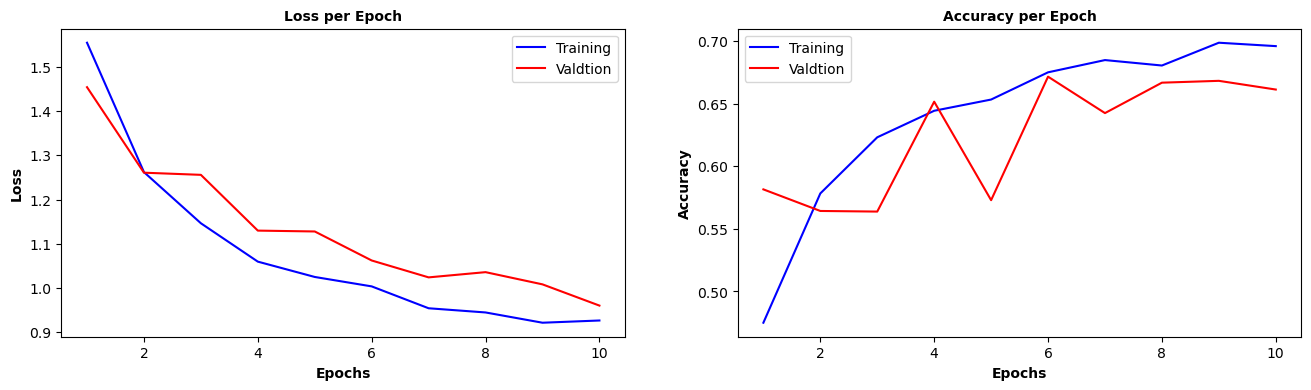

Accuracy : 0.6608884073672807 ,Error:0.3391115926327194 


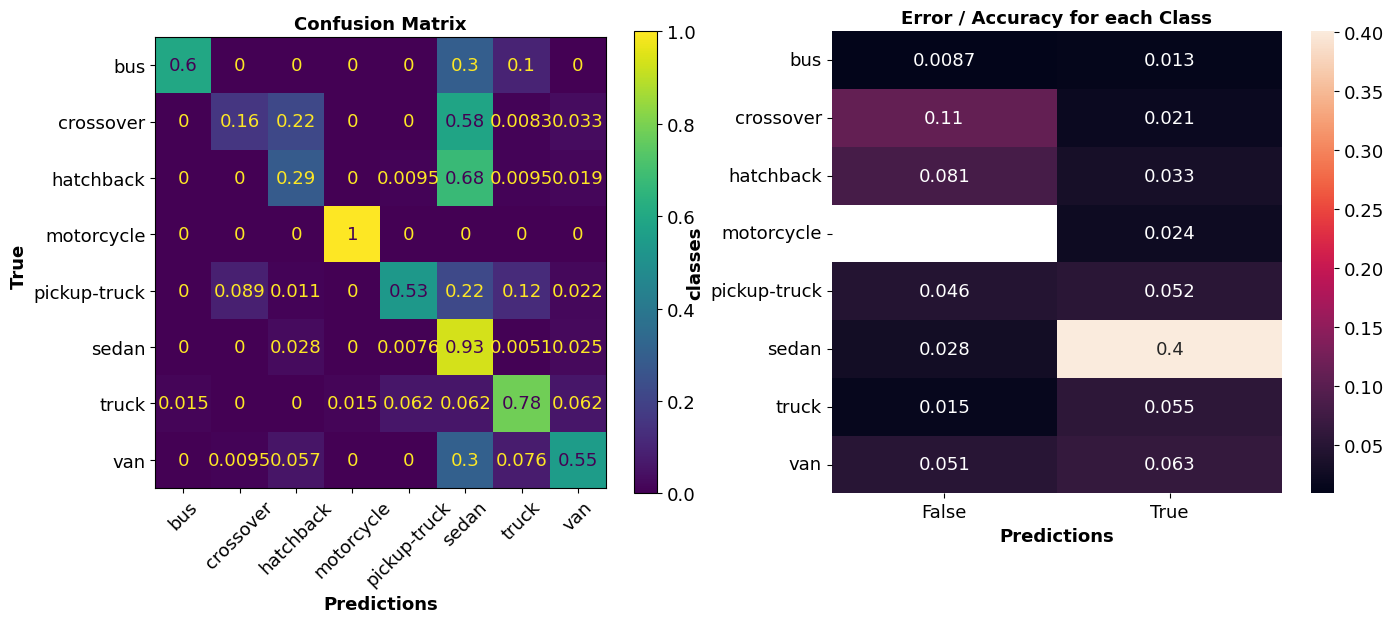

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy,epoch_time
5,1.003730,0.675000,1.062311,0.671532,40.071325
6,0.954248,0.684783,1.024098,0.642437,40.163657
7,0.944774,0.680435,1.035924,0.666732,40.074889
8,0.921555,0.698641,1.008302,0.668201,40.175295
9,0.926590,0.695924,0.960292,0.661246,40.030779


In [13]:
prams['epochs'] =10
prams['learning_rate']= 5e-4

#set_parameter_requires_grad(model, requires_grad=False)
#set_parameter_requires_grad(model.model.classifier, requires_grad=True)
optimizer = optim.NAdam( model.model.fc.parameters(),
                 lr=prams['learning_rate'], betas=prams['betas'] )
model.train_n_ep(prams['epochs'] ,loader_train,loader_val,criterion,optimizer )

model.plot_history()
_=model.model_data_monitor(loader_val, criterion)
model.history.tail()


In [ ]:
prams['epochs'] =30
prams['learning_rate']= 1e-3

#set_parameter_requires_grad(model, requires_grad=False)
#set_parameter_requires_grad(model.model.classifier, requires_grad=True)
optimizer = optim.NAdam( model.model.parameters(),
                 lr=prams['learning_rate'], betas=prams['betas'] )
model.train_n_ep(prams['epochs'] ,loader_train,loader_val,criterion,optimizer )

model.plot_history()
_=model.model_data_monitor(loader_val, criterion)
model.history.tail()


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 1, [LOSS]: 1.135044, [ACC]: 0.623 
[Val_LOSS]: 13.410636, [Val_ACC]: 0.220, [Val_F1]: 0.117


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 2, [LOSS]: 0.831130, [ACC]: 0.720 
[Val_LOSS]: 0.803303, [Val_ACC]: 0.710, [Val_F1]: 0.706
Best model on valdtion is Saved with metric :0.706


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 3, [LOSS]: 0.640140, [ACC]: 0.798 
[Val_LOSS]: 0.934184, [Val_ACC]: 0.730, [Val_F1]: 0.700


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 4, [LOSS]: 0.573819, [ACC]: 0.815 
[Val_LOSS]: 0.531845, [Val_ACC]: 0.831, [Val_F1]: 0.785
Best model on valdtion is Saved with metric :0.785


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 5, [LOSS]: 0.493505, [ACC]: 0.847 
[Val_LOSS]: 0.493238, [Val_ACC]: 0.843, [Val_F1]: 0.815
Best model on valdtion is Saved with metric :0.815


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 6, [LOSS]: 0.477048, [ACC]: 0.861 
[Val_LOSS]: 0.742785, [Val_ACC]: 0.791, [Val_F1]: 0.788


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 7, [LOSS]: 0.447168, [ACC]: 0.866 
[Val_LOSS]: 0.514673, [Val_ACC]: 0.843, [Val_F1]: 0.812


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 8, [LOSS]: 0.428814, [ACC]: 0.876 
[Val_LOSS]: 0.536610, [Val_ACC]: 0.828, [Val_F1]: 0.850
Best model on valdtion is Saved with metric :0.850


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 9, [LOSS]: 0.410505, [ACC]: 0.880 
[Val_LOSS]: 0.426206, [Val_ACC]: 0.873, [Val_F1]: 0.850
Best model on valdtion is Saved with metric :0.850


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 10, [LOSS]: 0.387906, [ACC]: 0.890 
[Val_LOSS]: 0.511456, [Val_ACC]: 0.855, [Val_F1]: 0.853
Best model on valdtion is Saved with metric :0.853


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 11, [LOSS]: 0.353015, [ACC]: 0.905 
[Val_LOSS]: 0.493467, [Val_ACC]: 0.856, [Val_F1]: 0.840


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 12, [LOSS]: 0.342925, [ACC]: 0.909 
[Val_LOSS]: 0.620422, [Val_ACC]: 0.783, [Val_F1]: 0.788


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 13, [LOSS]: 0.315586, [ACC]: 0.915 
[Val_LOSS]: 0.565756, [Val_ACC]: 0.843, [Val_F1]: 0.809


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 14, [LOSS]: 0.318891, [ACC]: 0.917 
[Val_LOSS]: 0.436173, [Val_ACC]: 0.879, [Val_F1]: 0.869
Best model on valdtion is Saved with metric :0.869


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 15, [LOSS]: 0.303216, [ACC]: 0.918 
[Val_LOSS]: 0.447215, [Val_ACC]: 0.855, [Val_F1]: 0.860


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 16, [LOSS]: 0.295643, [ACC]: 0.927 
[Val_LOSS]: 0.456646, [Val_ACC]: 0.876, [Val_F1]: 0.868


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 17, [LOSS]: 0.282806, [ACC]: 0.926 
[Val_LOSS]: 0.342892, [Val_ACC]: 0.907, [Val_F1]: 0.891
Best model on valdtion is Saved with metric :0.891


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 18, [LOSS]: 0.272109, [ACC]: 0.936 
[Val_LOSS]: 0.354346, [Val_ACC]: 0.914, [Val_F1]: 0.894
Best model on valdtion is Saved with metric :0.894


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 19, [LOSS]: 0.274671, [ACC]: 0.931 
[Val_LOSS]: 0.378479, [Val_ACC]: 0.896, [Val_F1]: 0.887


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 20, [LOSS]: 0.268439, [ACC]: 0.939 
[Val_LOSS]: 0.335585, [Val_ACC]: 0.917, [Val_F1]: 0.896
Best model on valdtion is Saved with metric :0.896


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 21, [LOSS]: 0.258897, [ACC]: 0.941 
[Val_LOSS]: 0.433177, [Val_ACC]: 0.892, [Val_F1]: 0.865


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 22, [LOSS]: 0.261256, [ACC]: 0.940 
[Val_LOSS]: 0.370834, [Val_ACC]: 0.908, [Val_F1]: 0.893


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 23, [LOSS]: 0.250279, [ACC]: 0.937 
[Val_LOSS]: 0.413506, [Val_ACC]: 0.911, [Val_F1]: 0.880


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 24, [LOSS]: 0.219364, [ACC]: 0.956 
[Val_LOSS]: 0.327063, [Val_ACC]: 0.913, [Val_F1]: 0.900
Best model on valdtion is Saved with metric :0.900


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 25, [LOSS]: 0.230901, [ACC]: 0.948 
[Val_LOSS]: 0.335677, [Val_ACC]: 0.916, [Val_F1]: 0.892


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 26, [LOSS]: 0.225144, [ACC]: 0.951 
[Val_LOSS]: 0.379887, [Val_ACC]: 0.902, [Val_F1]: 0.870


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 27, [LOSS]: 0.215693, [ACC]: 0.954 
[Val_LOSS]: 0.369980, [Val_ACC]: 0.904, [Val_F1]: 0.889


  0%|          | 0/230 [00:00<?, ?it/s]

[EPOCH]: 28, [LOSS]: 0.226961, [ACC]: 0.952 
[Val_LOSS]: 0.323260, [Val_ACC]: 0.919, [Val_F1]: 0.908
Best model on valdtion is Saved with metric :0.908


  0%|          | 0/230 [00:00<?, ?it/s]

## Monitor loss and acc per epoch

In [ ]:
model.plot_history()
_=model.model_data_monitor(loader_val, criterion)

In [ ]:
model.Load_Weights('Best_model_on_valdtion.pt')
model.plot_history()
_=model.model_data_monitor(loader_val, criterion)

In [ ]:
c= ''
add_Experiment(model, prams,optimizer,criterion,loader_val,transform_trian,transform_val,c,False)
#delet_Experiment('Exp_amr000000')